# Email Spam Detection
<!--
*** I'm using markdown "reference style" links for readability.
*** Reference links are enclosed in brackets [ ] instead of parentheses ( ).
*** See the bottom of this document for the declaration of the reference variables
*** This documentation will be finished when this projects finishes. 
-->
1. #### Importing libraries
        this are necessary libraries
            - pandas
            - numpy 
            - scikit-learn.preprocessing (LabelEncoder)

In [32]:
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import LabelEncoder
import matplotlib.pylab as plt
import nltk 
import seaborn as sns 
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

2. #### Collection of Data
        I use public datasets: 
            - Email-Spam-Classification-dataset-csv
            - Enron Email Dataset
            - deceptive-opinion-spam-corpus
            - spam-or-not-spam-dataset
            - spam-email
            - sms-spam-collection-dataset
            - email-spam-dataset
            - email-spam-classification-dataset-csv
        format: Each row is in text (message/email) and label (spam/ham).

In [2]:
complete_spam = pd.read_csv("dataset/completeSpamAssassin.csv", index_col=0)
null_rows = complete_spam[complete_spam.isnull().any(axis=1)]
complete_spam = complete_spam.dropna()
complete_spam.rename(columns={"Body": "message", "Label":'label'}, inplace=True)
complete_spam.head()

,message,label
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,##############################################...,1
4,I thought you might like these:\n1) Slim Down ...,1


In [3]:
enron = pd.read_csv("dataset\enronSpamSubset.csv", index_col=0)
enron = enron.drop(columns=["Unnamed: 0"])
enron.rename(columns={"Body": "message", "Label":'label'}, inplace=True)
enron.head()

,message,label
2469,Subject: stock promo mover : cwtd\n * * * urge...,1
5063,Subject: are you listed in major search engine...,1
12564,"Subject: important information thu , 30 jun 20...",1
2796,Subject: = ? utf - 8 ? q ? bask your life with...,1
1468,"Subject: "" bidstogo "" is places to go , things...",1


In [4]:
ling_spam = pd.read_csv("dataset\lingSpam.csv", index_col=0)
ling_spam.rename(columns={"Body": "message", "Label":'label'}, inplace=True)
ling_spam.head()

,message,label
0,Subject: great part-time or summer job !\n \n ...,1
1,Subject: auto insurance rates too high ?\n \n ...,1
2,Subject: do want the best and economical hunti...,1
3,Subject: email 57 million people for $ 99\n \n...,1
4,Subject: do n't miss these !\n \n attention ! ...,1


In [5]:
deceptive = pd.read_csv("dataset\deceptive-opinion.csv")
deceptive = deceptive.iloc[:, [2, 4]]
label = pd.get_dummies(deceptive['polarity'], drop_first=True)
deceptive.drop(columns=['polarity'], inplace=True)
new_deceptive = pd.concat([deceptive, label], axis=1)
new_deceptive.rename(columns={"text": "message", "positive":'label'}, inplace=True)
new_deceptive.head()

,message,label
0,We stayed for a one night getaway with family ...,True
1,Triple A rate with upgrade to view room was le...,True
2,This comes a little late as I'm finally catchi...,True
3,The Omni Chicago really delivers on all fronts...,True
4,I asked for a high floor away from the elevato...,True


In [6]:
spam = pd.read_csv("dataset\spam_or_not_spam.csv")
spam.rename(columns={'email': 'message'}, inplace=True)
spam.head()

,message,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


##### Shape of Dataset 

In [7]:
print(f"dataset 1 : {complete_spam.shape}")
print(f"dataset 2 : {spam.shape}")
print(f"dataset 3 : {new_deceptive.shape}")
print(f"dataset 4 : {ling_spam.shape}")
print(f"dataset 5 : {enron.shape}")
print(f"total expected shape : ({complete_spam.shape[0] + spam.shape[0] + new_deceptive.shape[0] + ling_spam.shape[0] + enron.shape[0]}, 2)")

dataset 1 : (6045, 2)
dataset 2 : (3000, 2)
dataset 3 : (1600, 2)
dataset 4 : (2605, 2)
dataset 5 : (10000, 2)
total expected shape : (23250, 2)


In [8]:
dfs = [complete_spam, spam, new_deceptive, ling_spam, enron]
spam_dataset = pd.concat(dfs, axis=0, ignore_index=True)
spam_dataset.tail()
print(spam_dataset.shape)

(23250, 2)


##### Checking Missing Values

In [9]:
spam_dataset.isnull().sum()

message    1
label      0
dtype: int64

##### Checking Duplicate Values

In [10]:
spam_dataset.duplicated().sum()

np.int64(1210)

##### Remove Duplicate Values

In [20]:
spam_dataset = spam_dataset.dropna()
spam_dataset = spam_dataset.drop_duplicates(keep='first')
spam_dataset.head()

,message,label
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,##############################################...,1
4,I thought you might like these:\n1) Slim Down ...,1


##### Final Shape of Dataset

In [23]:
print(f"After removing duplicate values. The final shape of dataset : {spam_dataset.shape}")

After removing duplicate values. The final shape of dataset : (22039, 2)


3. #### EDA aka Exploratory Data Analysis 
        The goal is to investigating data, understanding patterns, checking (anomalies, outliers), summarize key structure before applying any types of machine learning or statistical models. 


In [24]:
values = spam_dataset['label'].value_counts()
total = values[0] + values[1]

percentage_0 = (values[0] / total) * 100
percentage_1 = (values[1] / total) * 100

print(f"Percentage of target (ham) : {percentage_0}")
print(f"Percentage of target (spam) : {percentage_1}")

Percentage of target (ham) : 64.6626434956214
Percentage of target (spam) : 35.337356504378604


#### Pie Chart (Email Classification)

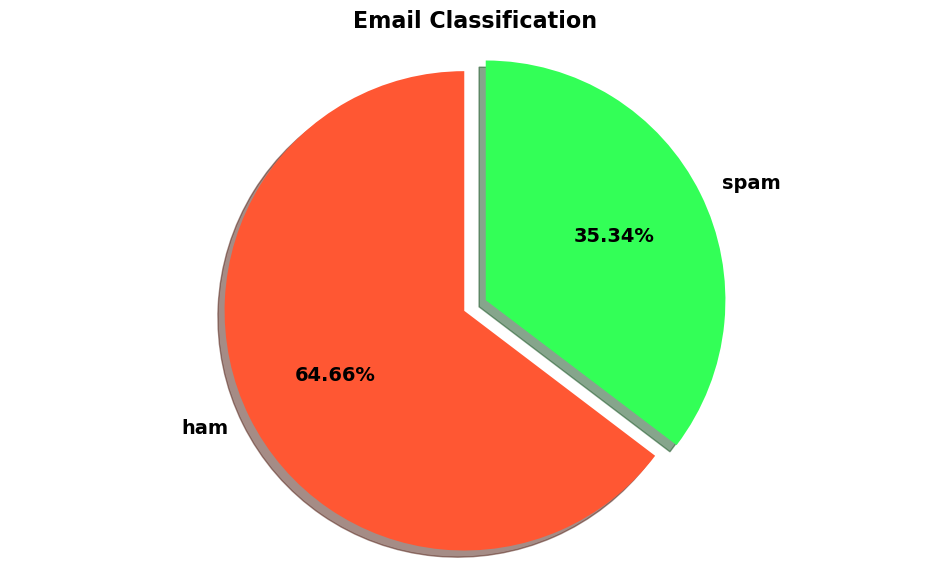

In [25]:
plt.figure(figsize=(12, 7)) # i know i 'm taking huge figure but i like that

colors = ['#FF5733', '#33FF57'] # red-oraney and green are my colors
myexplode = [0, 0.1]    # define explode parameter to create a gap between slices by 10% 
mylabels = ['ham', 'spam']  # ham and spam are categories 


plt.pie(
    values, 
    startangle=90,  # set angle 
    autopct='%0.2f%%',  # add percentage value 
    labels=mylabels, # labeling pie with ham and spam 
    explode=myexplode, # explode ham with 10%
    colors=colors,  # add your colors 
    shadow=True, # add shadow 
    textprops={'fontsize': 14, 'fontweight': 'bold'}    # add fontsize and weight
    )

plt.axis('equal')   #set axis equal so that pie looks circle 
plt.title("Email Classification", fontweight="bold", fontsize=16)
plt.show() 

#### Summary for Text, Chars, Sentences Length 

In [18]:
import re
def count_characters(text):
    words = re.findall(r'[a-zA-Z]', text)
    icount = 0 
    for w in words:
        if w.isdigit():
            continue
        icount = icount + 1
    return icount

In [27]:
spam_dataset['num_characters'] = spam_dataset['message'].apply(count_characters)
spam_dataset['num_words'] = spam_dataset['message'].apply(lambda x: len(nltk.word_tokenize(x)))
spam_dataset['num_sentences'] = spam_dataset['message'].apply(lambda x: len(nltk.sent_tokenize(x)))

spam_dataset[['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,2.203900e+04,2.203900e+04,22039.000000
mean,1.823136e+03,5.119527e+02,27.475430
std,8.046392e+04,2.441711e+04,1504.483484
min,0.000000e+00,0.000000e+00,0.000000
25%,3.170000e+02,8.800000e+01,3.000000
50%,6.200000e+02,1.740000e+02,8.000000
75%,1.244000e+03,3.480000e+02,16.000000
max,1.193657e+07,3.623500e+06,223247.000000


##### Summary Statistics for the legitimate message (emails)

In [29]:
spam_dataset[spam_dataset['label'] == 0 ][['num_characters', 'num_sentences', 'num_words']].describe()

,num_characters,num_sentences,num_words
count,1.425100e+04,14251.000000,1.425100e+04
mean,2.164088e+03,32.329872,6.163865e+02
std,1.000321e+05,1870.577373,3.036105e+04
min,3.000000e+00,1.000000,1.000000e+00
25%,3.310000e+02,3.000000,9.200000e+01
50%,6.770000e+02,7.000000,1.890000e+02
75%,1.312000e+03,15.000000,3.700000e+02
max,1.193657e+07,223247.000000,3.623500e+06


##### Summary Statistics for the spam messages (email)

In [35]:
spam_dataset[spam_dataset['label'] == 1][['num_characters', 'num_sentences', 'num_words']].describe()

,num_characters,num_sentences,num_words
count,7788.000000,7788.000000,7788.000000
mean,1199.238701,18.592450,320.852851
std,3354.267335,50.441562,615.707086
min,0.000000,0.000000,0.000000
25%,298.000000,5.000000,84.000000
50%,533.000000,9.000000,150.000000
75%,1084.000000,18.000000,300.000000
max,195468.000000,3093.000000,13292.000000


In [ ]:

plt.figure(figsize=(12, 7))

plt.hist(spam_dataset['label' == 0], color='blue')
,

sns.set(style='whitegrid')